# TensorFlow

참고 : TensorFlow Machine Learning Cookbook

In [1]:
import tensorflow as tf
sess = tf.Session()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np
import matplotlib.pyplot as plt

### 비선형 SVM 구현

In [3]:
# 데이터 로드
from sklearn import datasets
iris = datasets.load_iris()

x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y==0 else -1 for y in iris.target])

class1_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i]==-1]


# 일괄 작업 크기 선언
batch_size = 150


# 플레이스홀더 및 변수 선언
x_data = tf.placeholder(shape=[None,2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None,2], dtype=tf.float32)
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

In [4]:
def training(x_vals, y_vals, x_data, y_target, prediction_grid, b, gamma):
    # 가우시안 커널 선언
    gamma = tf.constant(-gamma)
    sq_dists = tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))
    my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))


    # 비용 함수 선언
    first_term = tf.reduce_sum(b)
    b_vec_cross = tf.matmul(tf.transpose(b),b)
    y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
    second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
    loss = tf.negative(tf.subtract(first_term, second_term))


    # 예측 커널 함수 생성
    rA = tf.reshape(tf.reduce_sum(tf.square(x_data),1), [-1,1])
    rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid),1),[-1,1])
    pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))),
                          tf.transpose(rB))
    pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))
    
    prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target), b), pred_kernel)
    prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))


    # 최적화 함수 선언
    my_opt = tf.train.GradientDescentOptimizer(0.01)
    train_step = my_opt.minimize(loss)


    # 변수 초기화
    init = tf.global_variables_initializer()
    sess.run(init)


    # 학습
    loss_vec = []
    batch_acc = []

    for i in range(300):
        rand_index = np.random.choice(len(x_vals), size=batch_size)
        rand_x = x_vals[rand_index]
        rand_y = np.transpose([y_vals[rand_index]])
        sess.run(train_step, feed_dict={x_data:rand_x, y_target:rand_y})
    
        temp_loss = sess.run(loss, feed_dict={x_data:rand_x, y_target:rand_y})
        loss_vec.append(temp_loss)
    
        acc_temp  = sess.run(accuracy, feed_dict={x_data:rand_x, y_target:rand_y, prediction_grid:rand_x})
        batch_acc.append(acc_temp)
    
        if(i+1) % 75 ==0:
            print('Gamma : {}'.format(sess.run(-gamma)))
            print('Step #{}'.format(str(i+1)))
            print('Losss = {}\n'.format(str(temp_loss)))
    print('-----'*10)
    
    
    # 모든 점에 대해 예측 수행
    x_min, x_max = x_vals[:,0].min() - 1, x_vals[:,0].max() + 1
    y_min, y_max = x_vals[:,1].min() - 1, x_vals[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    [grid_predictions] = sess.run(prediction, feed_dict={x_data:rand_x,
                                                         y_target:rand_y,
                                                         prediction_grid:grid_points})
    grid_predictions = grid_predictions.reshape(xx.shape)
    
    
    # 시각화
    plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
    plt.plot(class1_x, class1_y, 'ro', label='I. setosa')
    plt.plot(class2_x, class2_y, 'kx', label='Non setosa')
    plt.title('Gamma = {}'.format(sess.run(-gamma)))
    plt.xlabel('Petal Length')
    plt.ylabel('Sepal Width')
    plt.legend(loc='lower right')
    plt.ylim([-0.5, 3.0])
    plt.xlim([3.5, 8.5])

    
    return loss_vec, batch_acc


def batch_acc(batch_acc, gamma):
    plt.plot(batch_acc, 'k-', label='Accuracy')
    plt.title('Batch Accuracy, Gamma = {}'.format(gamma))
    plt.xlabel('Generation')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    
def loss_vec(loss_vec, gamma):
    plt.plot(loss_vec, 'k-')
    plt.title('Loss per Generation, Gamma = {}'.format(gamma))
    plt.xlabel('Generation')
    plt.ylabel('Loss')

Gamma : 1.0
Step #75
Losss = -101.30425

Gamma : 1.0
Step #150
Losss = -213.80417

Gamma : 1.0
Step #225
Losss = -326.30408

Gamma : 1.0
Step #300
Losss = -438.80417

--------------------------------------------------
Gamma : 10.0
Step #75
Losss = -113.31821

Gamma : 10.0
Step #150
Losss = -225.81813

Gamma : 10.0
Step #225
Losss = -338.31805

Gamma : 10.0
Step #300
Losss = -450.8182

--------------------------------------------------
Gamma : 25.0
Step #75
Losss = -138.71484

Gamma : 25.0
Step #150
Losss = -251.21475

Gamma : 25.0
Step #225
Losss = -363.7147

Gamma : 25.0
Step #300
Losss = -476.2149

--------------------------------------------------
Gamma : 100.0
Step #75
Losss = -98.67306

Gamma : 100.0
Step #150
Losss = -211.17299

Gamma : 100.0
Step #225
Losss = -323.6729

Gamma : 100.0
Step #300
Losss = -436.17303

--------------------------------------------------


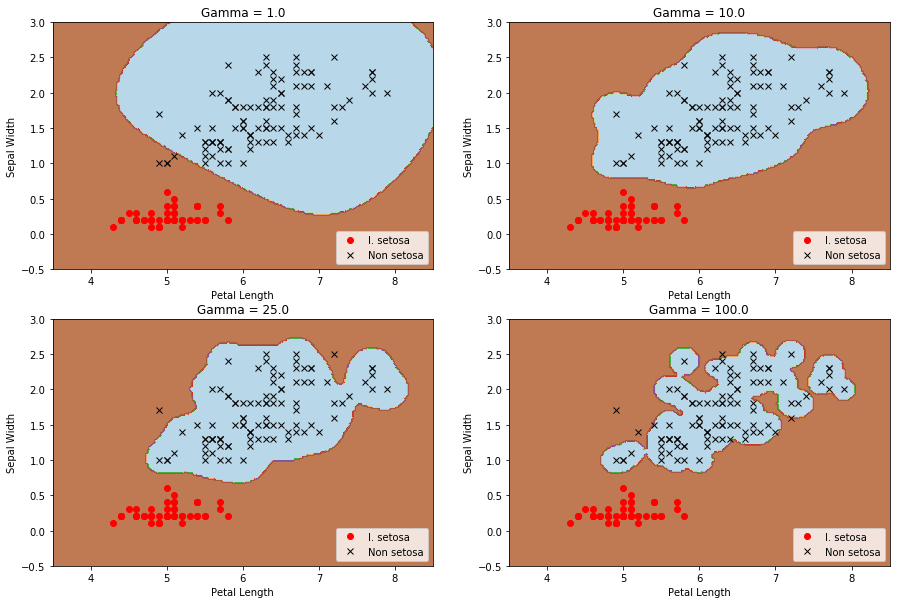

In [5]:
plt.figure(figsize=(15,10))
plt.subplot(221)
loss_vec_1, batch_acc_1 = training(x_vals, y_vals, x_data, y_target, prediction_grid, b, 1.0)

plt.subplot(222)
loss_vec_10, batch_acc_10 = training(x_vals, y_vals, x_data, y_target, prediction_grid, b, 10.0)

plt.subplot(223)
loss_vec_25, batch_acc_25 = training(x_vals, y_vals, x_data, y_target, prediction_grid, b, 25.0)

plt.subplot(224)
loss_vec_100, batch_acc_100 = training(x_vals, y_vals, x_data, y_target, prediction_grid, b, 100.0)

plt.show()

> gamma 값이 커짐에 따라 데이터 지점이 분류 경계에 미치는 효과가 더 커진다.

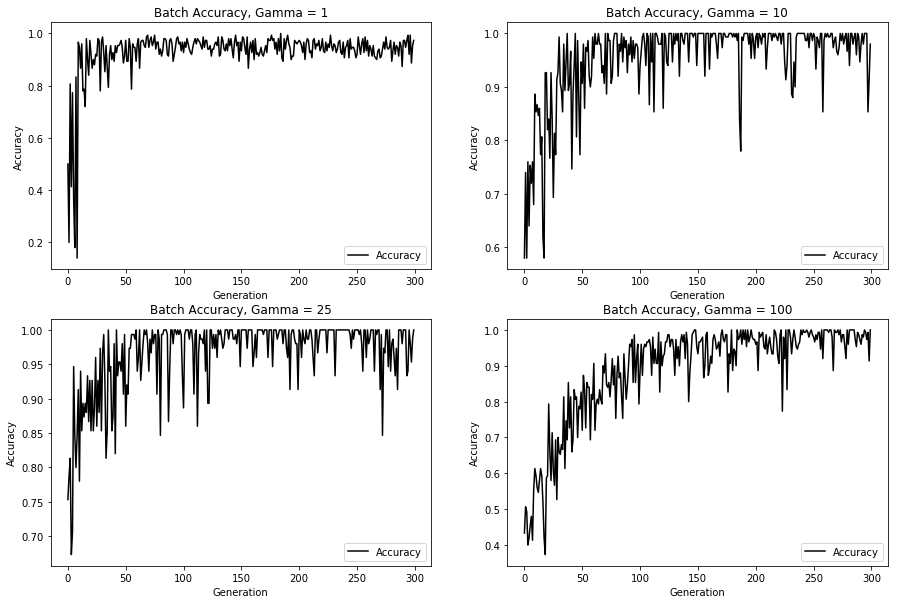

In [6]:
plt.figure(figsize=(15,10))
plt.subplot(221)
batch_acc(batch_acc_1, 1)

plt.subplot(222)
batch_acc(batch_acc_10, 10)

plt.subplot(223)
batch_acc(batch_acc_25, 25)

plt.subplot(224)
batch_acc(batch_acc_100, 100)

plt.show()

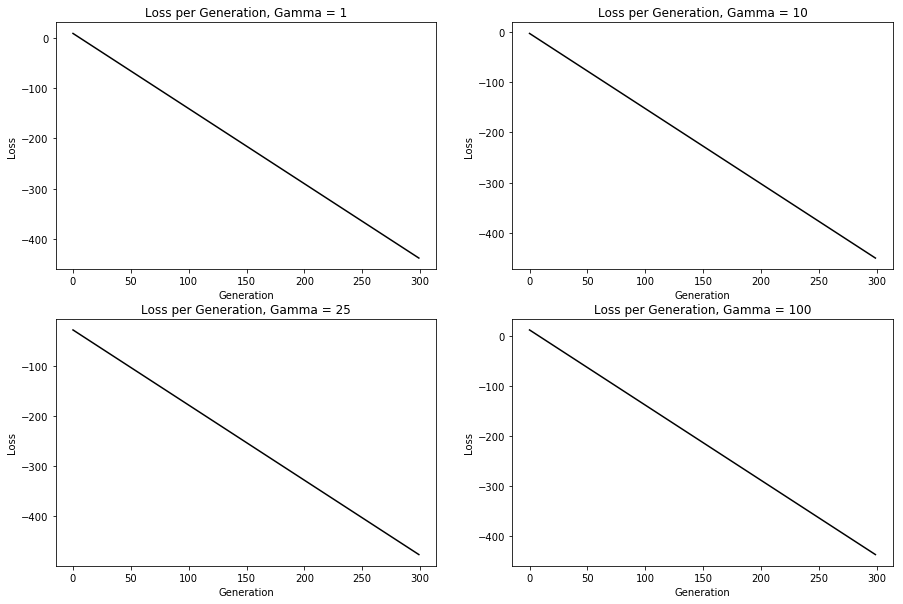

In [7]:
plt.figure(figsize=(15,10))
plt.subplot(221)
loss_vec(loss_vec_1, 1)

plt.subplot(222)
loss_vec(loss_vec_10, 10)

plt.subplot(223)
loss_vec(loss_vec_25, 25)

plt.subplot(224)
loss_vec(loss_vec_100, 100)

plt.show()